# MLonMCU

## Prerequisites

Before running this notebook, make sure to run the following steps:

1. Install the required software for your distribution:

   See main `README.md` file!
   
2. Clone this repository

   ```
   git clone https://github.com/tum-ei-eda/mlonmcu.git
   cd mlonmcu  # enter cloned repository
   ```
   
3. Setup and enter a new virtualenv (Python 3.7+) for using `mlonmcu`:

   ```
   python -m venv .venv
   source .venv/bin/activate
   ```
   
   Hint: You can also use a `conda` environment for this.
   
4. Install mlonmcu package

   ```
   make install  # alternative: python setup.py install
   ```
   
5. Install the required python packages:

   ``` 
   # pip install -r requirements.txt  # Done automatically via setup.py?
   pip install -r ipynb/requirements.txt
   ```
   
6. Launch this notebook in jupyter:

   ```
   jupyter notebook ipynb/Demo.ipynb
   ```

*Hint for Developers:* If you do not want to install MLonMCU first, you can just replace `mlonmcu` with `python -m mlonmcu.cli.main` in every command to just use the latest development version.

## Demonstration (Command Line)

### Preface

This guide should give an idea on the required steps to setup and use MLonMCU using the command line interface. Usage examples are provided as well.

### Initialize a MLonMCU environment

As MLonMCU requires a directory where dependencies, configurations, intermediate artifacts and results are stored, an environment needs to be initialized first. This also allows to use different configuration (e.g. enabled backends or supported features) for multiple environments.

Create and enter an environment diretcory first to initialize it afterwards:

In [10]:
# WARNING: execute this only once! Alternatively remove the environment directory beforehand to start from scratch.
!test -d /tmp/mlonmcu_env && echo "Skipped initialization on environment" \
  || mlonmcu init /tmp/mlonmcu_env --non-interactive --skip-sw

Initializing ML on MCU environment
Selected target directory: /tmp/mlonmcu_env
The directory does not exist! - Created directory.
Creating environment.yml based on template 'default'.
Skipping creation of virtual environment. (already inside one)
Initializing directories in environment: deps models
Finished. Please add `export MLONMCU_HOME=/tmp/mlonmcu_env` to your shell configuration to use it anywhere


When not using a notebook, the option `--non-interactive` can be omitted which allows to customize the initialization process interactively.

If the environment directory is not passed to the `mlonmcu` script, it will try to setup a `default` environment in the users home directory (On Ubuntu: `~/.config/mlonmcu/environments/default/`) instead. By providing a `--name` of the virtual environment if will be automatically registered in `~/.config/mlonmcy/environments.ini` for the current user which helps to find and distinguish multiple installed environments on a machine.

In the following the actual environment which should be used by the `mlonmcu` program has to be defined by the user either by defining the environment variable `MLONMCU_HOME` or by using the `-H` (`--home` or `--hint`) command line option. If none of this was done, the following rules are following to look for a suitable environment:

1. Check if `$MLONMCU_HOME` points to a valid environment
2. Use environment provided via the `-H` flag (path or registered name) if available
3. If the local working directory is the root of an environment, use this directory
4. If there is a default environment for the current user, fall back to this one instead

In [1]:
# Use this for bash: `export MLONMCU_HOME=/tmp/mlonmcu_env`
%env MLONMCU_HOME=/tmp/mlonmcu_env

env: MLONMCU_HOME=/tmp/mlonmcu_env


Registered environment can be listed via the command `mlonmcu env`. In addition there are possibilities to manually update entires in the environments file.

In [2]:
!mlonmcu env

Looking for user environments config file: /home/philipp/.config/mlonmcu/environments.ini
Found 1 mlonmcu environment(s):
    - default (/home/philipp/.config/mlonmcu/environments/default)
Point the environment variable MLONMCU_HOME to a environment directory to get started


### Customizing the created MLonMCU environment (optional)

The environment was initialized by a template which can be found in the `templates/` directory of the repository chosen via the `--template` flag. Lets inspect the generated configuration file first:

In [3]:
!cat $MLONMCU_HOME/environment.yml

---
# The MLONMCU_HOME is filled in automatically when creating the environment
home: "/tmp/mlonmcu_env"
logging:
  level: DEBUG
  to_file: false
  rotate: false
# Default locations for certain directoriescan be changed here
# Non-absolute paths will always be threated relative to the MLONMCU_HOME
paths:
  # Where the dependencies are downloaded and installed
  deps: deps
  # If logging to file is used keep logs in this directory
  logs: logs
  # Location where reports and artifacts are written to
  results: out
  # Directory for intermediate build products, should be located on a large enough drive
  temp: temp
  # A collection of models which will be used to look for models
  # The paths will be checked in the order defined here stopping at the first match
  # Non-existant paths will be skipped without throwing an error
  models:
    - "/tmp/mlonmcu_env/models"
    - "/home/philipp/.config/mlonmcu/models"
# Here default clone_urls
repos:
  tensorflow:
    url: "https://github.com/tum

The environment should work out of the box, but feel free to update the contents of the `environment.yml` file to achieve one of the following:

- Change the default paths used for dependencies, results, models,...
- Use different forks/versions of a repository
- Disable certain frameworks/backends to reduce the installation time in the next step.
- Define which features are supported for the given repositories
- Set default backends and targets
- Define a set of default configuration variables

To learn more about this, check out this document: `docs/ENVIRONMENTS.md` (TODO)

### Setting up all MLonMCU dependencies

Depending on the enabled backends and features, a different set of dependencies has to be installed. To reduce the management effort for the user, all these versions are installed and managed automatically using MLonMCU. To trigger this process, run the following in the command line. (This will take a very long time with all frameworks/targets/features enabled when invoked for the first time)

In [4]:
!mlonmcu setup

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Installing dependencies...
INFO - Processing task: clone_tensorflow
INFO - Processing task: clone_tflite_micro_compiler
INFO - Processing task: clone_etiss
INFO - Processing task: install_llvm
INFO - Processing task: clone_tvm
INFO - Processing task: clone_utvm_staticrt_codegen
INFO - Processing task: clone_muriscvnn
INFO - Processing task: install_riscv_gcc{'vext': False}
INFO - Processing task: install_riscv_gcc{'vext': True}
INFO - Processing task: build_tensorflow{'dbg': True}
INFO - Processing task: build_etiss{'dbg': False}
INFO - Processing task: build_tvm{'dbg': False}
INFO - Processing task: build_utvm_staticrt_codegen{'dbg': False}
INFO - Processing task: install_etiss{'dbg': False}
INFO - Processing task: build_etissvp{'dbg': False}
INFO - Processing task: build_muriscvnn
INFO - Processing task: build_tflite_micro_compiler{'dbg': False, 'muriscvnn': False}
INFO - Processing task: build_tf

Some things need to be considered here:
- Repositories are only cloned once, so upstream changes or updated urls/branches in the `environments.yml` are not detected automatically
- The flag `--rebuild` can be passed to `mlonmcu setup` to ensure that the setup routine of every dependency is triggered again. However this does not guarentee that all artifacts are properly updated
- To guarantee that the latest versions of a dependency are installed you can remove the `deps` directory manually or alternative use the provided `mlonmcu cleanup` utility. (Execute `mlonmcu cleanup --help` to learn more) 

### Adding models to MLonMCU

By default, the `mlonmcu-models` repository (https://github.com/tum-ei-eda/mlonmcu-models) is cloned to each environment as its contents are designed to perfectly integrate into the MLonMCU flow. In addition a location in the users home directory (`~/.config/mlonmcu/models/` for Ubuntu) is also added to the search path as defined in the `environments.yml`. Feel free to add further model manually or alternatively clone a model-zoo (e.g. https://github.com/ARM-software/ML-zoo) to a random location on the disc and updating the list of model-paths in the environments' config file.

To list all available models in a environment, the `mlonmcu models` subcommand can be used:

In [5]:
!mlonmcu models

INFO - Loading environment cache from file
INFO - Successfully initialized cache
Models Summary

Paths:
    /tmp/mlonmcu_env/models
    /home/philipp/.config/mlonmcu/models

Models:
    MobileNetV2
    MobileNetV2/MobileNet_V2
    aww
    bigsine_quant
    catdog
    catdog/CNN_2L_model_quantized
    catdog/CNN_full_quantized
    catdog/CNN_full_quantized_70_
    catdog/CNN_model
    catdog2
    cifar10
    lstm2
    magic_wand
    micro_speech
    mobilenetv1
    resnet
    simple_mnist
    simple_mnist/MNIST_best_model
    simple_mnist/MNIST_model
    simple_mnist/MNIST_model_quantized
    simple_mnist/model_data
    simple_mnist/model_data_pruned
    simple_mnist/model_data_size_optimized
    simple_mnist/test_model3_alex
    sine_model
    sine_model/hello_world
    ssd
    toycar
    vww

Groups:
    tinymlperf [4 models]
    minimal [1 models]
    tinymlbook [3 models]


The listed "Paths" should match the search paths defined in the `environments.yml` and are processed in the provided order. If there are multiple models of the same name, only the first one will be added to MLonMCU. By passing the `--detailed` flag to the command, additional information will be shown for each entry.

TODO: allow to search/filter for models by passing an extra arg

In addition to individual models, predefined model-groups are also available. I.e. the MLPerf Tiny benchmark defined here:

In [6]:
!cat $MLONMCU_HOME/models/modelgroups.yml

---
tinymlperf:
  - aww
  - vww
  - resnet
  - toycar

minimal:
  - sine_model

tinymlbook:
  - hello_world
  - micro_speech
  - magic_wand


Feel free to manualy define further model-groups for your needs.

### Running the MLonMCU flow

The MLonMCU flow is a major part of the tool and therefore explained by several examples, starting with minimal use cases before discussing more complex examples later.

**Invoke a single model on the default backend/target**

In [7]:
!mlonmcu flow run resnet

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Processing stage NOP
INFO - Processing stage LOAD
INFO - Processing stage BUILD
INFO - Processing stage COMPILE
INFO - Processing stage RUN
INFO - Done processing runs


While this looks pretty clean, in the background, there is a lot of thing being processed. You can find out more using the `--verbose` flag:

In [8]:
!mlonmcu flow run resnet --verbose

DEBUG - Restored 1 recent sessions
DEBUG - Enter MlonMcuContext
DEBUG - Locking context
INFO - Loading environment cache from file
INFO - Successfully initialized cache
DEBUG - Found match. Ignoring other files
DEBUG - Creating a new session with idx 1
DEBUG - Creating a new run with id 0
INFO - [session-1] Processing stage NOP
DEBUG - [session-1] [run-0] Continuing run from stage LOAD until stage NOP
DEBUG - [session-1] [run-0] Exporting run to disk
DEBUG - [session-1] [run-0] Writing run file
INFO - [session-1] Processing stage LOAD
DEBUG - [session-1] [run-0] Continuing run from stage LOAD until stage LOAD
DEBUG - [session-1] [run-0] Processing stage LOAD
DEBUG - [session-1] [run-0] Exporting run to disk
DEBUG - [session-1] [run-0] Writing run file
INFO - [session-1] Processing stage BUILD
DEBUG - [session-1] [run-0] Continuing run from stage BUILD until stage BUILD
DEBUG - [session-1] [run-0] Processing stage BUILD
DEBUG - - Executing: ('/mnt/c/Users/ga87puy/src/mlonmcu/.venv/bin/p

The report of a run is typically the first thing to check out after invoking MLonMCU. It will be automatically written to the `results` directory declared in the `environments.yml`:

In [9]:
!ls $MLONMCU_HOME/out/*.csv

/tmp/mlonmcu_env/out/unnamed_20220131T091440.csv
/tmp/mlonmcu_env/out/unnamed_20220131T091526.csv


Let's define some helper functions to print these reports as a table. Of course you could also just open them i.e. with Excel! 

In [7]:
from helpers import tabularize_latest_report

In the following line the results or the latest run should be printed as a Pandas dataframe:

In [11]:
tabularize_latest_report()

,Session,Run,Model,Frontend,Framework,Backend,Target,Num,Total Cycles,Total ROM,Total RAM,ROM read-only,ROM code,ROM misc,RAM data,RAM zero-init data,Features,Config,Comment
0,1,0,resnet,tflite,tvm,tvmaot,etiss_pulpino,1,672032000,259596,124872,168688,90764,144,2500,122372,[],"{'export_optionals': False, 'tflite.use_inout_...",-


The artifacts for every invocation of the MLonMCU flow can be found in directory inside the environment. Your can find the latest files like this:

In [12]:
!tree -L 3 $MLONMCU_HOME/temp/sessions/latest/

/tmp/mlonmcu_env/temp/sessions/latest/
├── report.csv
└── runs
    ├── 0
    │   ├── aot_wrapper.c
    │   ├── codegen
    │   ├── generic_mlif
    │   ├── metadata.json
    │   ├── metrics.csv
    │   ├── mlif
    │   ├── parameters
    │   ├── report.csv
    │   ├── resnet.tflite
    │   ├── run.txt
    │   ├── src
    │   └── tvm_wrapper.h
    └── latest -> /tmp/mlonmcu_env/temp/sessions/1/runs/0

7 directories, 9 files


However there is a more komfortable way to do this: `mlonmcu export`

In [13]:
#!mkdir -p /tmp/some_directory
#!mlonmcu export /tmp/some_directory  # By default this exports the last run of the lastest session

Check out `mlonmcu export --help` to learn learn how to get the most out of this command. There is also a utility called `mlonmcu cleanup` which helps to get rid of old files after exporting the useful ones.

There exist multiple stages which can be processed. The subcommand passed to `mlonmcu flow` defines the stage where the flow should stop. If you are only interested in intermediate artifacts of the process, use one of the following:

```
mlonmcu flow load  # only process the model with the frontend
mlonmcu flow build  # invoke the chosen backend to generate code
mlonmcu flow compile  # (cross-)compile the code for the chosen target
```

Further commands are available to achive further behavior:

```
mlonmcu flow test  # use provided model-data to invoke the models comparing their outputs with a golden reference
```

**Explicitly specify the backend and target to use for the flow**

In [14]:
!mlonmcu flow run sine_model --backend tvmaot --target host_x86

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - [session-2] Processing stage NOP
INFO - [session-2] Processing stage LOAD
INFO - [session-2] Processing stage BUILD
INFO - [session-2] Processing stage COMPILE
INFO - [session-2] Processing stage RUN
INFO - [session-2] Done processing runs


**Enable certain features for all defined runs**

In [15]:
# !mlonmcu flow run toycar --backend tvmaot --target etiss_pulpino --feature unpacked_api

**Add additional configuration options to customize internal components**

In [16]:
!mlonmcu flow run resnet --backend tvmaot --config tvmaot.target_device=arm_cpu

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - [session-3] Processing stage NOP
INFO - [session-3] Processing stage LOAD
INFO - [session-3] Processing stage BUILD
INFO - [session-3] Processing stage COMPILE
INFO - [session-3] Processing stage RUN
INFO - [session-3] Done processing runs


Instead of defining certain key-value pass on aeach command line, feel free to use the `vars:` property defined in the `environment.yml` to achieve the same result.

**Invoke multiple models on multiple backends/targets**

In [17]:
!time mlonmcu flow run resnet toycar --backend tvmaot --backend tflmc  --target etiss_pulpino

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - [session-4] Processing stage NOP
INFO - [session-4] Processing stage LOAD
INFO - [session-4] Processing stage BUILD
INFO - [session-4] Processing stage COMPILE
INFO - [session-4] Processing stage RUN
INFO - [session-4] Done processing runs

real	2m48.146s
user	5m9.750s
sys	0m25.591s


**Exploit parallelism to reduce the processing time**

In [18]:
!time mlonmcu flow run resnet toycar --backend tvmaot --backend tflmc --target etiss_pulpino --parallel 4 --config runs_per_stage=0

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - [session-5] Processing stage NOP
INFO - [session-5] Processing stage LOAD
INFO - [session-5] Processing stage BUILD
INFO - [session-5] Processing stage COMPILE
INFO - [session-5] Processing stage RUN
INFO - [session-5] Done processing runs

real	2m11.051s
user	5m37.539s
sys	0m28.384s


**Inspecting and exporting results and intermediate artifacts**

In [19]:
# !mlonmcu export --session 0 --run 0 run.zip
# !mlonmcu export --session 0 session.zip
# !mlonmcu export session/

### Further MLonMCU usage

In [20]:
# TODO

## Demonstration (Python API)

### Preface

While it is also possible to initialize and setup an MLonMCU environment via Python, it is highly recommended to use the provided command line interfaces for these steps. The following examples demonstrate how to use the MLonMCU flow from within a Python program which enables more customizations of the internal features via scripting.

### Open a MLonMCU context to load the environment

In [1]:
%env MLONMCU_HOME=/tmp/mlonmcu_env

env: MLONMCU_HOME=/tmp/mlonmcu_env


### Running the MLonMCU flow

In [4]:
import mlonmcu.context
from mlonmcu.models.lookup import lookup_models

with mlonmcu.context.MlonMcuContext() as context:
    session = context.create_session()
    run = session.create_run(features=[], config={})
    run.add_model_by_name("tinymlperf")
    run.add_frontend_by_name("tflite")
    run.add_backend_by_name("tvmaot")
    run.add_target_by_name("host_x86")
    # session.process_runs()
    df = session.get_reports()

INFO - Loading environment cache from file
INFO - Successfully initialized cache


Now we have the dataframe of the run we just defined and right in out python environment so we can have more fun with it.

In [5]:
!time mlonmcu flow run tinymlperf --backend tflmc --target etiss_pulpino --parallel 4 --config runs_per_stage=0

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - [session-10] Processing stage NOP
INFO - [session-10] Processing stage LOAD
INFO - [session-10] Processing stage BUILD
INFO - [session-10] Processing stage COMPILE
INFO - [session-10] Processing stage RUN
INFO - [session-10] Done processing runs

real	2m41.777s
user	8m30.905s
sys	0m22.042s


In [8]:
df = tabularize_latest_report()
df

,Session,Run,Model,Frontend,Framework,Backend,Target,Num,Total Cycles,Total ROM,Total RAM,ROM read-only,ROM code,ROM misc,RAM data,RAM zero-init data,Features,Config,Comment
0,10,0,aww,tflite,tflite,tflmc,etiss_pulpino,1,618081000,248496,26480,56472,191876,148,2548,23932,[],"{'export_optionals': False, 'runs_per_stage': ...",-
1,10,1,vww,tflite,tflite,tflmc,etiss_pulpino,1,1769630000,482392,105880,290368,191876,148,2548,103332,[],"{'export_optionals': False, 'runs_per_stage': ...",-
2,10,2,resnet,tflite,tflite,tflmc,etiss_pulpino,1,2603900000,300458,58124,106912,193398,148,2552,55572,[],"{'export_optionals': False, 'runs_per_stage': ...",-
3,10,3,toycar,tflite,tflite,tflmc,etiss_pulpino,1,10645500,398618,5788,286088,112382,148,2536,3252,[],"{'export_optionals': False, 'runs_per_stage': ...",-


Let's add a quick visualization:

<AxesSubplot:>

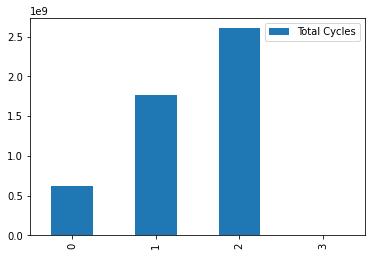

In [10]:
new_df = df[["Model", "Backend", "Total Cycles"]]
new_df.plot(kind="bar")

### Low level APIs

In [ ]:
# TODO

Core components of MLonMC (Frontends, Backends, Targets) can also be invoked individually as demonstrated in the following examples:

In [ ]:
# TODO